# Homework 4: Systems of Equations

In [1]:
import Pkg; Pkg.add("Plots");
using LinearAlgebra; using Plots; default(fmt=:png);
BLAS.set_num_threads(1);

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`


In [2]:
bigspy(A; kwargs...) = spy(A, m=4; kwargs...)

bigspy (generic function with 1 method)

## 1. (T&B Exercise 20.2)

Suppose $A \in \mathbb{C}^{m \times m}$ has an LU factorization (by T&B Exercise 20.1, this is true if and only if for each $1 \leq k \leq m$ the upper-left $k \times k$ block $A_{1:k,1:k}$ is nonsingular) and is banded with bandwidth $2p + 1$, i.e., $a_{ij} = 0$ for $|i - j| > p$.

### 1.(a) [5%]

Create a random $20 \times 20$ matrix $A$ with bandwidth $2p + 1 = 5$, i.e. $p=2$, and compute its LU factorization $A = LU$ (without pivoting: see the [documentation](https://docs.julialang.org/en/v1/stdlib/LinearAlgebra/#LinearAlgebra.lu) to determine how to turn off pivoting in `lu`).  Plot the matrices $A$, $L$ and $U$ using the `bigspy` command.

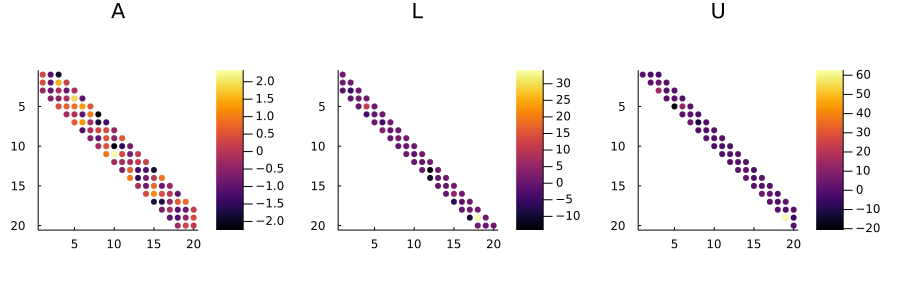

In [3]:
m = 20
p = 2

A = randn(m,m)
for i in 1:m
    for j in 1:m
        if abs(i - j) > p
            A[i,j] = 0
        end
    end
end

L, U = lu(A, NoPivot())
a = bigspy(A, title="A")
l = bigspy(L, title="L")
u = bigspy(U, title="U")
plot(a,l,u,layout=(1,3), size=(900,300))

### 1.(b) [5%]

Without adding the plots here, try the same for different values of $p$ until you see a pattern in the sparsity patterns of $L$ and $U$.  State what that pattern is and prove that it holds for general $p$.

The bandwidth of $L$ and $U$ are the same, i.e., $\ell_{ij} = 0$ and $u_{ij} = 0$ if $|i - j| > p$.

Without pivoting the first row of $U$ and the first column of $L$ (both of which will be unchanged in subsequent iterations) have this property.  The only change to the trailing block $A_{2:m,2:m}$ (assuming the factorization is done in place) is the rank one update, $A_{2:m,2:m} \gets A_{2:m,2:m} - L_{2:m,1} U_{1,2:m}$, but the only nonzero part of $L_{2:m,1} U_{1,2:m}$ is $L_{2:p-1,1} U_{1,2:p-1}$, has the same bandwidth.  Therefore, after the update, $A_{2:m,2:m}$ has the same bandwith $2p+1$ as before.  Because the factorization is computed recursively on this updated matrix, the facts about the first column of $L$ and first row of $U$ will also be true for the second column/row, third, etc.  This completes the proof.

## 2. (T&B Exercise 21.2)

### 2.(a) [5%]

Repeat 1.(a), but this time with partial pivoting, and generate the same three plots.

74

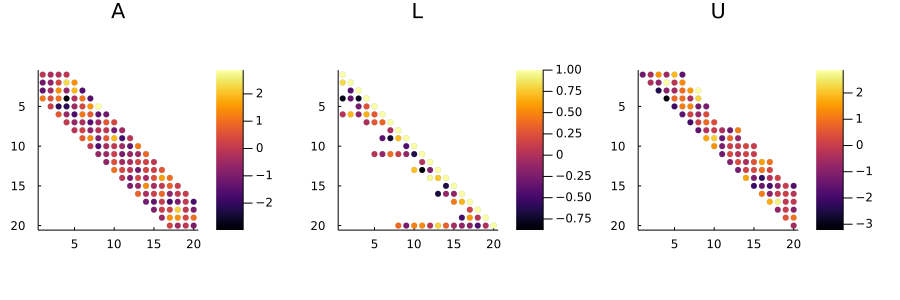

In [4]:
m = 20
p = 3

A = randn(m,m)
for i in 1:m
    for j in 1:m
        if abs(i - j) > p
            A[i,j] = 0
        end
    end
end

L, U = lu(A)
display(sum(L .!= 0))
a = bigspy(A, title="A")
l = bigspy(L, title="L")
u = bigspy(U, title="U")
plot(a,l,u,layout=(1,3), size=(900,300))

### 2.(b) [5%]

What can be said about the bandedness of $U$?  Specifically, you should determine $p_U$ such that the bandwidth of $U$ is at most $2p_U + 1$ as a function of $p$. (Again, you may want to test your result on several random inputs until you see a pattern.) Prove your result.

If $A$ has bandwidth $2p+1$ then $U$ will have bandwidth $4p + 1$, i.e. $u_{ij} = 0$ if $|i - j| >  2p$.

Proof:  Although $A$ is has the bandwidth $2p+1$, suppose that $a_{ij}$ can also be nonzero if $1 \leq i \leq p+1$ and $1 \leq j \leq 2p+1$.

The pivot row will be some $\hat{\imath}$ where $1 \leq \hat{\imath} \leq p+1$, since those are the only rows where $a_1$ is nonzero.

After the row exchange, $A$ will still have the property that $a_{ij}$ is nonzero if $|i-j| > p$ or
$1 \leq i \leq p+1$ and $1 \leq j \leq 2p+1$, which means that the bandwidth of just the first row of $U$ will be $|4p + 1|$,  $u_{1j} = 0$ if  $|1 - j| > 2p$.

After the rank-one update, $A_{2:m,2:m} \gets A_{2:m,2:m} - \ell_{2:m,1} u_{1,2:m}$, $A_{2:m,2:m}$ will have the same nonzero structure that $A$ it was assumed $A$ had.  Therefore the nonzero structure of the first row of $U$ will also be the nonzero structure of the second row of $U$, and the third, etc. This completes the proof.

### 2.(c) [5%]

What is the most nonzeros entries $n_L$ that are in any column of $L$? Prove your result.

There will be at most $p+1$ nonzeros in any column of $L$.

Assume $A$ has the same nonzero structure described in the proof of 2(b).  After the row pivot, the number of nonzeros in the first column of $L$ will be the same as the number of nonzeros in the first column of $A$, which is $p+1$.  Subsequent row exchanges will not change the number of nonzeros, so that is how many there will be in that column at the conclusion of the LU factorization algorithm.  The proof of 2(b) showed the assumed nonzero structure of $A$ is the same as the nonzero structure of $A_{2:m,2:m}$ after the rank one update, which shows that each subsequent column of $L$ also has $p+1$ nonzeros.

## 3. (T&B Exercise 20.4) [10%]

Write the LU factorization algorithm (without pivoting) using just one explicit `for` loop.  Inside this loop, $U$ will be updated at each step by a certain rank-one outer product.  This "outer product" form of Gaussian elimination may be a better starting point if one wants to optimize computer performance.

In [5]:
function lu_one_loop(A)
    """
    Compute the LU factorization of A using one explicit for loop.
    
    Arguments:
    
    - `A`: A square matrix
    
    Returns:
    
    - `L`: A unit lower triangular matrix
    
    - `U`: An upper triangular matrix such that A = L*U
    """
    ### BEGIN SOLUTION
    m = size(A)[1]
    L = Matrix(one(eltype(A))*I, m, m)
    U = copy(A)
    for k in 1:m
        L[(k+1):m,k] = U[(k+1):m,k] ./ U[k,k]
        U[(k+1):m,k] .= 0
        U[(k+1):m,(k+1):m] .-= L[(k+1):m,[k]] * U[[k],(k+1):m]
    end
    ### END SOLUTION
    return L, U
end

lu_one_loop (generic function with 1 method)

In [6]:
function generate_random_lu_data(T, m)
    """
    Generate a random matrix that is guaranteed to have an LU factorization without pivoting.
    
    Arguments:
    
    - `T`: A datatype
    - `m`: A positive integer
    
    Returns:
    
    - `A`: an m × m matrix that has an LU factorization
    """
    
    A = randn(T, m, m)
    col_sum = abs.(A)' * ones(m)
    signs = sign.(diag(A))
    A += 1.1 * diagm(col_sum .* signs)
    return A
end

generate_random_lu_data (generic function with 1 method)

In [7]:
# Test on real inputs
m = 15
A = generate_random_lu_data(Float64, m);

In [8]:
# Q3: Run `lu_one_loop` on real inputs
L, U = lu_one_loop(A);

In [9]:
# Q3: Real L is lower triangular
@assert(norm(L - LowerTriangular(L)) == 0)

In [10]:
# Q3: Real L is unit lower triangular
@assert(norm(diag(L) - ones(m)) == 0)

In [11]:
# Q3: Real U is upper triangular
@assert(norm(U - UpperTriangular(U)) == 0)

In [12]:
# Q3: Real LU is close to A
ρ_est = sqrt(m) # average case observed growth factor
@assert(norm(A - L*U) <= 100 * eps() * ρ_est * norm(A))

In [13]:
# Test on complex inputs
m = 15
A = generate_random_lu_data(Complex{Float64}, m);

In [14]:
# Q3: Run `lu_one_loop` on complex inputs
L, U = lu_one_loop(A);

In [15]:
# Q3: Complex L is lower triangular
@assert(norm(L - LowerTriangular(L)) == 0)

In [16]:
# Q3: Complex L is unit lower triangular
@assert(norm(diag(L) - ones(m)) == 0)

In [17]:
# Q3: Complex U is upper triangular
@assert(norm(U - UpperTriangular(U)) == 0)

In [18]:
# Q3: Complex LU is close to A
ρ_est = sqrt(m) # average case observed growth factor
@assert(norm(A - L*U) <= 100 * eps() * ρ_est * norm(A))

## 4. (T&B Exercise 21.6) [10%]

You'll notice that `generate_random_lu_data` first creates a matrix and then adds a multiple of the column sum
$\sum_{i} |a_{ij}|$ to the diagonal $a_{jj}$, and that the result should have an LU factorization without pivoting.

Suppose $A \in \mathbb{C}^{m \times m}$ is _strictly column diagonally dominant_, which means that for each $k$,

$$|a_{kk}| > \sum_{j \neq k} |a_{jk}|.$$

Show that if Gaussian elimination with partial pivoting is applied to $A$, no row interchanges take place.

$a_{11}$ will be selected as the first pivot because $|a_{11}|$ is the unique maximizer of $|a_{i1}|$.

After the rank-one update, the updated values of $A_{2:m,2:m}$ will be,

$$
\hat a_{ij} = a_{ij} - \frac{a_{i1}}{a_{11}} a_{1j}.
$$

We will show that after this update $A_{2:m,2:m}$ is still strictly column diagonally dominant, which is sufficient to prove that there will never be a row interchange.

After the update,

$$
\begin{aligned}
|\hat a_{kk}| &= \left|a_{kk}
- \frac{a_{k1}}{a_{11}} a_{1k}\right| \\
&\geq |a_{kk}| - \left|\frac{a_{k1}}{a_{11}} a_{1k}\right| \\
&> \left(\sum_{\substack{j = 1 \\ j \neq k}}^m |a_{jk}| \right) - \left|\frac{a_{k1}}{a_{11}} a_{1k}\right|,
\end{aligned}
$$
where we have used the triangle inequality and strict column diagonal dominance of column $k$.

We use the strict column diagonal dominance of the the first column to bound the second term:

$$
\begin{aligned}|a_{11}| &> \sum_{j=2}^m |a_{j1}| \\
\Rightarrow
|a_{k1}| &< |a_{11}| - \sum_{\substack{j = 2 \\ j \neq k}}^m |a_{j1}| 
\\
\Rightarrow
\left|\frac{a_{k1}}{a_{11}}\right| &< 1 - \sum_{\substack{j = 2 \\ j \neq k}}^m \left|\frac{a_{j1}}{a_{11}}\right|
\\
\Rightarrow
-\left|\frac{a_{k1}}{a_{11}}a_{1k}\right| &> \sum_{\substack{j = 2 \\ j \neq k}}^m \left|\frac{a_{j1}}{a_{11}}a_{1k}\right| - |a_{1k}|
\end{aligned}
$$

Therefore,

$$
\begin{aligned}
|\hat a_{kk}|
&> \sum_{\substack{j = 1 \\ j \neq k}}^m |a_{jk}|  + \sum_{\substack{j = 2 \\ j \neq k}}^m \left|\frac{a_{j1}}{a_{11}}a_{1k}\right| - |a_{1k}| \\
&= \sum_{\substack{j = 2 \\ j \neq k}}^m |a_{jk}| + \left|\frac{a_{j1}}{a_{11}}a_{1k}\right| \\
&\geq \sum_{\substack{j = 2 \\ j \neq k}}^m \left|a_{jk} -\frac{a_{j1}}{a_{11}}a_{1k}\right| =
\sum_{\substack{j = 2 \\ j \neq k}}^m | \hat a_{jk} |,
\end{aligned}
$$
where we have again used the triangle inequality. This shows that $A_{2:m,2:m}$ is strictly column diagonally dominant after the update.

## 5. (T&B Exercise 22.2)

### 5.(a) [5%]

Write a function that for a given $m$ generate an $m \times m$ matrix $A$ for which the backward error of
pivoted LU factorization, $\tilde{L}\tilde{U} = \tilde{P} A + \delta A$ grows like the pessimistic bound

$$\frac{\max_{ij} |(\delta A)_{ij}|}{\max_{ij} |A_{ij}|} = O(2^{m-1} \epsilon_{\text{machine}}).$$

In particular, your method should generate matrices such that the following bounds hold:

| $m$ | $\max_{ij} |(\delta A)_{ij}| / \max_{ij} |A_{ij}|$ |
| :-: | :-: |
| $30$  | $\geq 2^{20} \epsilon_{\text{machine}}$ |
| $40$  | $\geq 2^{30} \epsilon_{\text{machine}}$ |
| $50$  | $\geq 2^{40} \epsilon_{\text{machine}}$ |

In [19]:
function catastrophic_growth_factor_matrix(m)
    """
    Construct a matrix with nearly pessimistic growth factor
    
    Arguments:
    
    - `m`: An integer
    
    Returns:
    
    - `A`: An m × m matrix whose growth factor (computed with julia's `lu`) is close
           to the upper bound 2ᵐ⁻¹.
    """
    ### BEGIN SOLUTION
    A = UnitLowerTriangular(-ones(m,m))[:,:]
    A[:,m] .= 1
    A += diagm(eps() * ones(m))
    ### END SOLUTION
    return A
end

catastrophic_growth_factor_matrix (generic function with 1 method)

In [20]:
# Q5: test m = 30
m = 30
A = catastrophic_growth_factor_matrix(m)
f = lu(A)
rel_err = norm(f.P * A - f.L * f.U, Inf) / norm(A, Inf)
@assert rel_err >= eps() * 2.0 ^ (m - 10)

In [21]:
# Q5: test m = 40
m = 40
A = catastrophic_growth_factor_matrix(m)
f = lu(A)
rel_err = norm(f.P * A - f.L * f.U, Inf) / norm(A, Inf)
@assert rel_err >= eps() * 2.0 ^ (m - 10)

In [22]:
# Q5: test m = 50
m = 50
A = catastrophic_growth_factor_matrix(m)
f = lu(A)
rel_err = norm(f.P * A - f.L * f.U, Inf) / norm(A, Inf)
@assert rel_err >= eps() * 2.0 ^ (m - 10)

### 5.(b) [5%]

Make a plot of the backward relative errors $\max_{ij} |(\delta A)_{ij}| / \max_{ij} |A_{ij}|$ for your matrices for values $m=10, 11, \dots, 60$.  Make $m$ the x-axis and the relative error the y-axs, and make the y-axis a logarithmic scale.
Add a trend line for $2^{m-1} \epsilon_{\text{machine}}$ to your plot to show what the asymptotic growth looks like in the worst case.

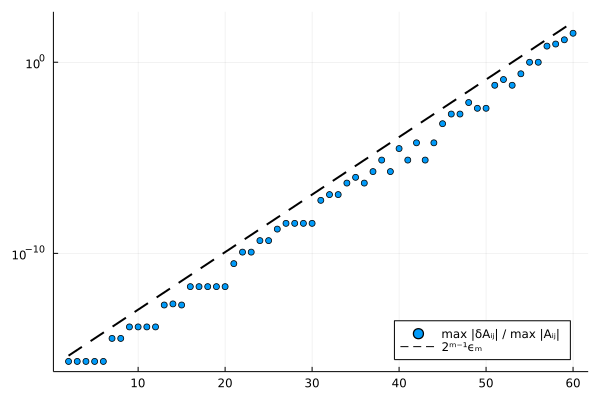

In [23]:
backward_rel_errs = Float64[]
ms = 2:60
for m in ms
    A = catastrophic_growth_factor_matrix(m)
    f = lu(A)
    append!(backward_rel_errs, norm(f.P * A - f.L * f.U, Inf) / norm(A, Inf))
end
plot(ms, max.(eps(), backward_rel_errs), yscale=:log10, st=:scatter, label="max |δAᵢⱼ| / max |Aᵢⱼ|")
plot!(ms, eps() .* 2.0 .^(ms .- 1), l = (:black, :dash, 2), label="2ᵐ⁻¹ϵₘ", legend=:bottomright)

## 6. (T&B Exercise 22.4)

### 6.(a) [5%]

Suppose $PA = LU$ (LU factorization with partial pivoting) and $A = QR$ (QR factorization).  Describe a relationship between the last row of $L^{-1}$ and the last column of $Q$, and prove why this relationship is so.

Let $\alpha = \frac{u_{mm}}{r_{mm}}$: then the last row of $L^{-1}$ is a permutation of $\alpha q_m^*$, where $q_m$ is the last column of $Q$:

$$\begin{aligned}
PA &= LU, \\
\Rightarrow L^{-1} P &= U R^{-1} Q^*.
\end{aligned}
$$

The last row of $Q^*$ is $q_m^*$; $U$ and $R^{-1}$ are both upper triangular, so the last row of
$U R^{-1} Q^*$ is $u_{mm} r_{mm}^{-1} q_m^*$.  On the left the last row of $L^{-1} P$ is a permutation of the last row of $L^{-1}$.

### 6.(b) [5%]

Show that if $A$ is random in the sense of having independent, normally distributed entries, then its column spaces are randomly oriented, so that in particular, the last column of $Q$ is a random unit vector.

If $A$ is random as decribed, then each column $a_j$ has a random direction: each direction (corresponding to a point on the $m-1$-dimensional unit sphere in $\mathbb{C}^m$) is equally likely.  This means that the columns of $U A$ have the same distribution for any unitary $U$.  In particular, suppose $q_m$ is the actual last column of $Q$ and let $\hat q_m$ be any other unit vector.  There is a unitary matrix $U$ such that $U q_m = \hat q_m$,
so $\hat q_m$ is the last column of the QR factorization of $UA$.  But because $UA$ has columns with the same probability distribution as $A$, the likelihood of $\hat q_m$ as the last column of $Q$ is the same as $q_m$.

### 6.(c) [5%]

Combine the results of (a) and (b) to make a statement about the final row of $L^{-1}$ in Gaussian elimination applied to a random matrix $A$.

If the last column of $q_m$ is a random unit vector with every direction being equally likely, then
$q_m^* P$ is a row vector where every direction is equally likely.  Thus the last row of $L^{-1}$ of a random matrix is a scaled random vector where every direction is equally likely.

## 7.

### 7.(a) [5%]

Give an example of a $3 \times 3$ matrix $A$ in block form

$$
A = \begin{bmatrix} F & B \\ B^* & 0 \end{bmatrix},
$$

where:

- $F$ is a $2 \times 2$ symmetric positive definite matrix and $\kappa(F) \geq 10^{10}$, and
- $\kappa(A) < 2$.

$$A = \begin{bmatrix}
1 & 0 & 0 \\
0 & 10^{-10} & 1 \\
0 & 1 & 0
\end{bmatrix}$$

This matrix is a small perturbation of a permutation matrix (which always has condition number 1): it's condition number is $\approx 1$.  But it's $F$ block has condition number $10^{10}$ (because its diagonal contains its singular values).

## 7.(b) [5%]

Consider the problem of solving the system of equations

$$
\begin{bmatrix}
C & B \\ B^* & 0
\end{bmatrix}
\begin{bmatrix}
x \\ y
\end{bmatrix}
=
\begin{bmatrix}
f \\ g
\end{bmatrix},
$$

where $C$ is symmetric positive definite and $B \in \mathbb{C}^{m \times n}$ ($m \geq n$) has full rank.  Suppose we solve this system in the following steps:

1. Compute the Cholesky factorization $C = LL^*$.
2. Compute $w = g - B^*C^{-1} f = g - B^* L^{-*} L^{-1} f$.
3. Compute the matrix $S= B^* C^{-1} B = B^* L^{-*} L^{-1} B$.
4. Compute the Cholesky factorization $G G^* = S$.
5. Compute $y = -S^{-1} w = - G^{-*} G^{-1} w$.
6. Compute $z = f - B y$.
7. Compute $x = C^{-1} z = L^{-*} L^{-1}z$.

Why does part $A$ suggest that this is method may be unstable?

Because the intermediate steps (2.) and (7.) involve solving a system in the $C$ block, which may have a much worse condition number than the condition number of the original problem.

### 7.(c) [10%]

Now suppose we consider only problems where $g = 0$,

$$
\begin{bmatrix}
C & B \\ B^* & 0
\end{bmatrix}
\begin{bmatrix}
x \\ y
\end{bmatrix}
=
\begin{bmatrix}
f \\ 0
\end{bmatrix},
$$

so that $y = (B^* C^{-1} B)^{-1} B^* C^{-1} f.$

Prove that there is a bound $\psi_B$ such that

$$\|(B^* C^{-1} B)^{-1} B^* C^{-1}\| \leq \psi_B, \quad \text{for all symmetric positive definite }C.$$

This suggests that the condition number of $\kappa_{C \to y}$ is independent of $C$.

_Hint:_ Use two SVDs: one of $B$, one of $B^* C^{-1}$.

This question will not be graded.

## 8. 

### 8.(a) [6%]

Write an implementation of a rank-one Cholesky update: assuming $L L^* = A$ is a Cholesky factorization of $A$,
compute $H H^* = A + u u^*$, the Cholesky factorization of the rank-one update of $A$.

Unlike a Cholesky factorization from scratch, your implementation should use $O(m^2)$ operations.

You are welcome to consult [existing implementations](https://en.wikipedia.org/wiki/Cholesky_decomposition#Updating_the_decomposition), but your implementation will have to be valid for complex-valued $A$ and $u$.

In [24]:
function cholesky_update(L, u)
    """
    Update a Cholesky factorization by a rank one update,
    
        H H' = L L' + u u'
    
    Arguments:
    
    - `L`: An existing lower-triangular Cholesky factor
    
    - `u`: The vector for the rank-one update
    
    Returns:
    
    - `H`: the lower-triangular Cholesky factor of `L L' + u u'`
    
    """
    ### BEGIN SOLUTION
    m = size(L)[1]
    H = copy(L)
    v = copy(u)
    for k in 1:m
        λ = H[k,k]
        υ = v[k]
        ρ = λ'λ + υ'υ
        η = H[k,k] = √ρ
        l = H[(k+1):m,k]
        w = v[(k+1):m]
        h = H[(k+1):m,k] = (λ' * l + υ' * w) / η
        v[k+1:m] = (λ * w - υ * l) / η
    end
    ### END SOLUTION
    return H
end

cholesky_update (generic function with 1 method)

In [25]:
# Q8.(a): Run cholesky_update on real input
m = 50
B = randn(m,m)
A = B' * B
L = cholesky(A).L
u = randn(m)
Au = A + u*u'
H = cholesky_update(L, u);

In [26]:
# Q8.(a): Real Cholesky factor is lower triangular
@assert(norm(H - LowerTriangular(H)) == 0)

In [27]:
# Q8.(a): Real Cholesky factor has small backward error
@assert(norm(Au - H * H') / norm(Au) <= eps() * 100)

In [28]:
# Q8.(a): Run cholesky_update on complex input
m = 50
B = randn(Complex{Float64}, m,m)
A = B' * B
L = cholesky(A).L
u = randn(Complex{Float64}, m)
Au = A + u*u'
H = cholesky_update(L, u);

In [29]:
# Q8.(a): Complex Cholesky factor is lower triangular
@assert(norm(H - LowerTriangular(H)) == 0)

In [30]:
# Q8.(a): Complex Cholesky factor has small backward error
@assert(norm(Au - H * H') / norm(Au) <= eps() * 100)

### 8.(b) [4%]

Suppose that we only want to solve the system $(A + u u^*) x = b$.

Again assume that $L L^* = A$ is a Cholesky factorization of $A$, but instead of updating the factorization, write a function that solves the system using the [Woodbury formula](https://en.wikipedia.org/wiki/Woodbury_matrix_identity).

In [31]:
function solve_cholesky_update(L, u, b)
    """
    Solve (L L' + u u') x = b
    
    Arguments:
    
    - `L`: An existing lower-triangular Cholesky factor
    
    - `u`: The vector for the rank-one update
    
    Returns:
    
    - `x` : the solution of (L L' + u u') x = b
    """
    ### BEGIN SOLUTION
    v = L \ u
    y = L \ b
    α = -1 / (1 + v' * v)
    z = y + α * v * (v' * y)
    x = L' \ z
    ### END SOLUTION
    return x
end

solve_cholesky_update (generic function with 1 method)

In [32]:
# Q8.(b): Run solve_cholesky_update on real input
m = 50
B = randn(m,m)
A = B' * B
L = cholesky(A).L
u = randn(m)
b = randn(m)
Au = A + u*u'
x = solve_cholesky_update(L, u, b);

In [33]:
# Q8.(b): Real cholesky update solve has small backward error
@assert(norm(Au * x - b) / norm(b) <= eps() * 1.e5)

In [34]:
# Q8.(b): Run solve_cholesky_update on complex input
m = 50
B = randn(Complex{Float64}, m,m)
A = B' * B
L = cholesky(A).L
u = randn(Complex{Float64}, m)
b = randn(Complex{Float64}, m)
Au = A + u*u'
x = solve_cholesky_update(L, u, b);

In [35]:
# Q8.(b): Complex cholesky update solve has small backward error
@assert(norm(Au * x - b) / norm(b) <= eps() * 1.e5)